In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
df = pd.read_csv("datos_españa.csv")

df["t2m_C"] = df["t2m"] - 273.15

df["lat_zone"] = df["latitude"].round(2)
df["lon_zone"] = df["longitude"].round(2)

df["date"] = pd.to_datetime(df["valid_time"]).dt.date

df_dana = df[df["msl"] < 100000]

dana_events = df_dana.groupby(["date", "lat_zone", "lon_zone"]).agg({
    "msl": ["min", "mean"],
    "t2m_C": ["min", "mean"],
    "latitude": "first",
    "longitude": "first"
}).reset_index()

dana_events.columns = [
    "date", "lat_zone", "lon_zone",
    "msl_min", "msl_mean", "t2m_min_C", "t2m_mean_C",
    "latitude", "longitude"
]

dana_events.to_csv("posibles_danas_detectadas_españa.csv", index=False)

print(dana_events.head())

Exportado: posibles_danas_detectadas.csv
         date  lat_zone  lon_zone   msl_min      msl_mean  t2m_min_C  \
0  2022-03-30      35.0      2.50  99976.50  99976.500000   14.61367   
1  2022-03-30      35.0      2.75  99952.50  99968.875000   15.27383   
2  2022-03-30      35.0      3.00  99933.00  99952.375000   16.50040   
3  2022-03-30      35.0      3.25  99927.25  99955.916667   13.35732   
4  2022-03-30      35.0      3.50  99918.00  99941.750000   13.46670   

   t2m_mean_C  latitude  longitude  
0   14.613670      35.0       2.50  
1   16.440700      35.0       2.75  
2   16.924100      35.0       3.00  
3   15.237780      35.0       3.25  
4   14.843897      35.0       3.50  


In [ ]:
import pandas as pd

df = pd.read_csv("posibles_danas_detectadas_españa.csv")

def clasificar_impacto(row):
    if row["msl_min"] > 99500 and row["t2m_mean_C"] >= 10:
        return "Bajo riesgo"
    elif 99000 < row["msl_min"] <= 99500:
        return "Medio"
    elif row["msl_min"] <= 99000:
        return "Alto riesgo"
    else:
        return "Riesgo indeterminado"

if "impacto_dana" not in df.columns:
    df["impacto_dana"] = df.apply(clasificar_impacto, axis=1)

danas_alto = df[df["impacto_dana"] == "Alto riesgo"]

danas_alto.to_csv("danas_impacto_alto.csv", index=False)

print("Se han detectado", len(danas_alto), "DANAs de impacto alto.")
print(danas_alto.head(10))

Se han detectado 6671 DANAs de impacto alto.
             date  lat_zone  lon_zone    msl_min      msl_mean  t2m_min_C  \
7156   2022-12-12     44.00    -10.00  98955.560  99505.171667   14.62660   
7157   2022-12-12     44.00     -9.75  98954.310  99520.933571   14.42350   
7158   2022-12-12     44.00     -9.50  98981.060  99513.924000   14.18325   
11393  2023-01-17     41.25      4.25  98997.560  99220.106875   11.84440   
11394  2023-01-17     41.25      4.50  98993.310  99231.023542   11.15493   
11395  2023-01-17     41.25      4.75  98992.310  99239.242292   10.24282   
11396  2023-01-17     41.25      5.00  98996.810  99252.294375    9.44204   
11429  2023-01-17     41.50      2.50  98990.125  99206.117292    8.72915   
11430  2023-01-17     41.50      2.75  98964.625  99181.158958    9.76626   
11431  2023-01-17     41.50      3.00  98951.625  99169.075625   10.26040   

       t2m_mean_C  latitude  longitude impacto_dana  
7156    15.208652     44.00     -10.00  Alto riesgo  

In [ ]:
df = pd.read_csv("posibles_danas_detectadas_españa.csv")

def clasificar_impacto(row):
    if row["msl_min"] > 99500 and row["t2m_mean_C"] >= 10:
        return "Bajo riesgo"
    elif 99000 < row["msl_min"] <= 99500:
        return "Medio"
    elif row["msl_min"] <= 99000:
        return "Alto riesgo"
    else:
        return "Riesgo Indeterminado"

df["impacto_dana"] = df.apply(clasificar_impacto, axis=1)

danas_alto = df[df["impacto_dana"] == "Alto riesgo"].copy()

def asignar_region(lat, lon):
    if 36 <= lat <= 38.5 and -9 <= lon <= -3:
        return "Andalucía"
    elif 38.5 <= lat <= 41 and -6.5 <= lon <= -1:
        return "Zona centro"
    elif 38 <= lat <= 41.5 and -1 <= lon <= 3.5:
        return "Levante (Valencia/Cataluña)"
    elif 41.5 <= lat <= 44 and -2.5 <= lon <= 3.5:
        return "Noreste"
    elif 36 <= lat <= 38 and -2 <= lon <= 1.5:
        return "Sureste (Murcia/Almería)"
    elif 41.5 <= lat <= 44.5 and -9.5 <= lon <= -5.5:
        return "Galicia"
    elif 38 <= lat <= 40 and -7.5 <= lon <= -4:
        return "Extremadura"
   

danas_alto["region_aproximada"] = danas_alto.apply(
    lambda row: asignar_region(row["latitude"], row["longitude"]), axis=1)

danas_alto["fecha"] = pd.to_datetime(danas_alto["date"]).dt.date

danas_unicas = danas_alto.groupby(["fecha", "region_aproximada"]).agg({
    "msl_min": "min",
    "t2m_mean_C": "mean",
    "latitude": "first",
    "longitude": "first"
}).reset_index()

top_20_eventos = danas_unicas.sort_values(by=["msl_min", "t2m_mean_C"]).head(20)

print("Top 20 DANAs únicas más peligrosas por región:\n")
print(top_20_eventos[["fecha", "region_aproximada", "msl_min", "t2m_mean_C", "latitude", "longitude"]])

top_20_eventos.to_csv("top20_danas_por_region.csv", index=False)

📊 Top 20 DANAs únicas más peligrosas por región:

         fecha            region_aproximada    msl_min  t2m_mean_C  latitude  \
8   2023-10-20                      Galicia  97960.310   13.038075     42.25   
10  2023-10-20                      Noreste  98028.310   14.375872     41.50   
4   2023-10-19                      Galicia  98036.625   14.585714     41.50   
44  2024-10-09                      Galicia  98097.810   17.644849     41.75   
25  2024-02-10                      Noreste  98175.250    7.988549     41.50   
36  2024-03-27                      Noreste  98196.000    9.121851     41.75   
6   2023-10-19                      Noreste  98239.190   16.797183     41.50   
35  2024-03-27                      Galicia  98243.250    7.292657     41.50   
3   2023-10-17                      Galicia  98267.440   20.734537     41.75   
21  2024-02-09                      Noreste  98305.190   10.436318     41.50   
28  2024-03-09                      Galicia  98306.060    8.072594    

c:\Users\PEPE BENEYTO\Documents\ANACONDA\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 127786 (\N{CLOUD WITH TORNADO}) missing from current font.
  super()._update_title_position(renderer)
c:\Users\PEPE BENEYTO\Documents\ANACONDA\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 127786 (\N{CLOUD WITH TORNADO}) missing from current font.
  super()._update_title_position(renderer)
c:\Users\PEPE BENEYTO\Documents\ANACONDA\Lib\site-packages\cartopy\mpl\geoaxes.py:524: UserWarning: Glyph 127786 (\N{CLOUD WITH TORNADO}) missing from current font.
  return super().draw(renderer=renderer, **kwargs)


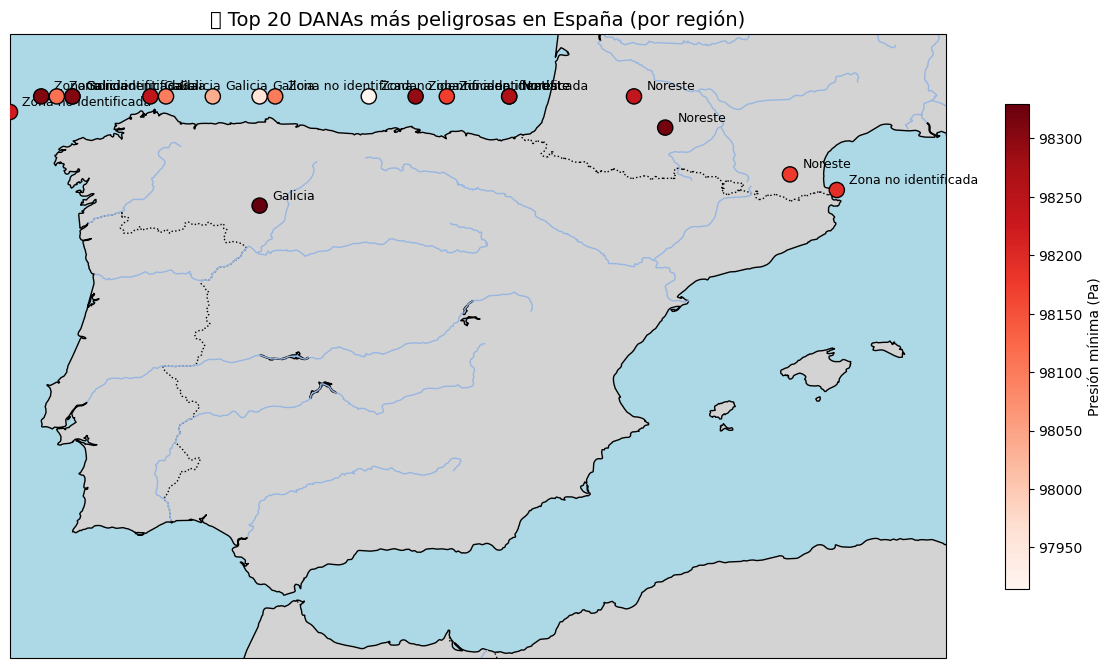

In [ ]:
df = pd.read_csv("danas_impacto_alto.csv")

def asignar_region(lat, lon):
    if 36 <= lat <= 38.5 and -7 <= lon <= -3:
        return "Andalucía"
    elif 38.5 <= lat <= 41 and -6 <= lon <= -1:
        return "Centro"
    elif 39 <= lat <= 41.5 and 0 <= lon <= 3:
        return "Levante"
    elif 41.5 <= lat <= 44 and -2 <= lon <= 3:
        return "Noreste"
    elif 36 <= lat <= 38 and -1.5 <= lon <= 1:
        return "Sureste"
    elif 42 <= lat <= 44 and -9 <= lon <= -6:
        return "Galicia"
    elif 38 <= lat <= 40 and -7.5 <= lon <= -5:
        return "Extremadura"
    else:
        return "Zona no identificada"

if "region_aproximada" not in df.columns:
    df["region_aproximada"] = df.apply(lambda row: asignar_region(row["latitude"], row["longitude"]), axis=1)

df["date"] = pd.to_datetime(df["date"])
df_unicos = df.sort_values(by="msl_min").drop_duplicates(subset=["date", "region_aproximada"])
top_20 = df_unicos.head(20)

plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 5, 35, 45], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)

scatter = ax.scatter(
    top_20["longitude"], top_20["latitude"],
    c=top_20["msl_min"], cmap="Reds", s=120, edgecolor="k", zorder=5
)

for _, row in top_20.iterrows():
    ax.text(row["longitude"] + 0.2, row["latitude"] + 0.1, row["region_aproximada"], fontsize=9)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, pad=0.05)
cbar.set_label("Presión mínima (Pa)")
plt.title("Top 20 DANAs más peligrosas en España (por región)", fontsize=14)
plt.tight_layout()
plt.show()